# Classification of drawings made in the game 'Quick, draw!'

https://github.com/kradolfer/quickdraw-image-recognition

Author: David Kradolfer, June 2017 (updated 19.9.2017)

In this project I will use scikit-learn and Keras to compare different machine learning algorithms to classify drawings made in the game ['Quick, draw!'](https://quickdraw.withgoogle.com/). In this game, people are told what they should draw in less than 20 seconds, while a neural network is predicting in real-time what it sees in the drawing. Once the prediction is correct, you can't finish your drawing, which might explain the rather minimalistic style of the drawings. It's not the most fun game, but certainly a great way of collecting data for machine learning. 

A huge dataset has been made publically available, more information is available in this [Github repository](https://github.com/googlecreativelab/quickdraw-dataset). I have used [this data set](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1), which is already preprocessed to a uniform 28x28 pixel image size. Since the complete data set includes over 50 million pictures and 345 categories, I will only use a small subset of it.


In [1]:
# Imports

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

K.set_image_data_format('channels_first')

## Binary Classification

I will start with only 2 classes, cat and sheep drawings. There [data](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1) for each class consists of around 125'000 drawings (rows) and 784 pixels (columns) per drawing.

In [9]:
# load the data
cat = np.load('data/cat.npy')
sheep = np.load('data/sheep.npy')

print(cat.shape)
print(sheep.shape)

(123202, 784)
(126121, 784)


In [10]:
# add a column with labels, 0=cat, 1=sheep
cat = np.c_[cat, np.zeros(len(cat))]
sheep = np.c_[sheep, np.ones(len(sheep))]

Two useful functions: I wrote one to plot 28x28 pixel images from numpy arrays and will use one to plot the confusion matrix from the [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

In [11]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''

    fig, ax = plt.subplots(figsize=(cols, rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array), (rows * cols)))):
        a = fig.add_subplot(rows, cols, i + 1)
        imgplot = plt.imshow(input_array[i, :784].reshape((28, 28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

In [12]:
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 5)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's take a look at some drawings. The quality and style of the drawings varies greatly, so we should expect a lower accuracy than in other tasks such as digit recognition. Also, the data set is not completely cleaned.

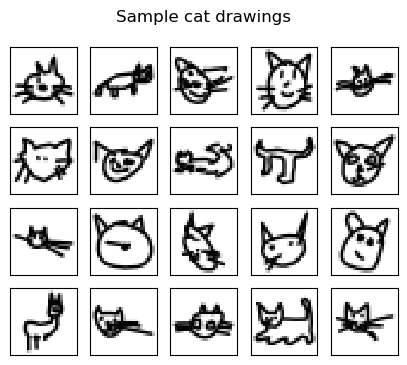

In [13]:
plot_samples(cat, title='Sample cat drawings\n')

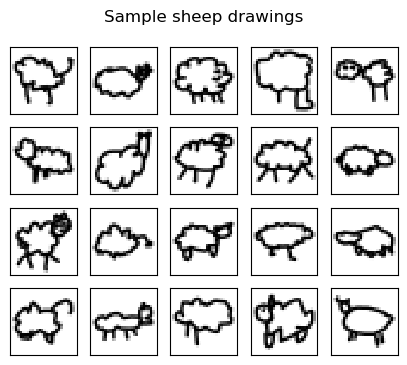

In [14]:
plot_samples(sheep, title='Sample sheep drawings\n')

Create the matrices for scikit-learn (5'000 cat and sheep images each):

In [15]:
# merge the cat and sheep arrays, and split the features (X) and labels (y). Convert to float32 to save some memory.
X = np.concatenate((cat[:5000, :-1], sheep[:5000, :-1]), axis=0).astype('float32')  # all columns but the last
y = np.concatenate((cat[:5000, -1], sheep[:5000, -1]), axis=0).astype('float32')  # the last column

# train/test split (divide by 255 to obtain normalized values between 0 and 1)
# I will use a 50:50 split, since I want to start by training the models on 5'000 samples and thus have plenty of samples to spare for testing.
X_train, X_test, y_train, y_test = train_test_split(X / 255., y, test_size=0.5, random_state=0)

## Random Forest

I will first try out a simple random forest classifier using the default options (except for random_state for reproducibility and n_jobs=-1 to use multiple CPUs):

In [26]:
%%time

clf_rf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf_rf.fit(X_train, y_train)
print(clf_rf)
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print('Random forest accuracy: ', acc_rf)

RandomForestClassifier(n_jobs=-1, random_state=0)
Random forest accuracy:  0.9044
CPU times: total: 7.8 s
Wall time: 1.4 s


The most important argument, n_estimators (= number of trees in the forest), is set to 10 by default. Let's try some larger values, as that should increase accuracy. GridSearchCV is very useful for optimizing parameters in scikit-learn.

In [17]:
parameters = {'n_estimators': [10, 20, 40, 60, 80, 100, 120, 140, 160]}

In [18]:
%%time

clf_rf = RandomForestClassifier(n_jobs=-1, random_state=0)
rf = GridSearchCV(clf_rf, parameters, n_jobs=-1)
rf.fit(X_train, y_train)

results = pd.DataFrame(rf.cv_results_)

CPU times: total: 16.2 s
Wall time: 25.7 s


In [20]:
results.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,8.204199,0.542622,0.719954,0.570285,160,{'n_estimators': 160},0.922,0.908,0.909,0.925,0.924,0.9176,0.007499,1
7,8.706045,0.465645,1.542387,1.953365,140,{'n_estimators': 140},0.920,0.907,0.911,0.923,0.924,0.9170,0.006782,2
6,7.900558,0.208546,3.282807,1.330891,120,{'n_estimators': 120},0.921,0.908,0.910,0.921,0.924,0.9168,0.006493,3
4,5.333318,0.709832,1.483018,1.201923,80,{'n_estimators': 80},0.916,0.909,0.908,0.926,0.918,0.9154,0.006560,4
5,5.376832,0.303015,2.704791,1.332851,100,{'n_estimators': 100},0.916,0.907,0.909,0.921,0.921,0.9148,0.005879,5
3,3.152155,0.217495,0.660239,0.581816,60,{'n_estimators': 60},0.913,0.908,0.911,0.922,0.919,0.9146,0.005161,6
2,2.128074,0.178598,1.057828,0.435544,40,{'n_estimators': 40},0.905,0.903,0.909,0.926,0.916,0.9118,0.008376,7
1,0.982908,0.192893,1.500841,0.137368,20,{'n_estimators': 20},0.892,0.896,0.892,0.905,0.896,0.8962,0.004750,8
0,0.685497,0.018714,0.058850,0.018145,10,{'n_estimators': 10},0.876,0.879,0.868,0.887,0.882,0.8784,0.006344,9


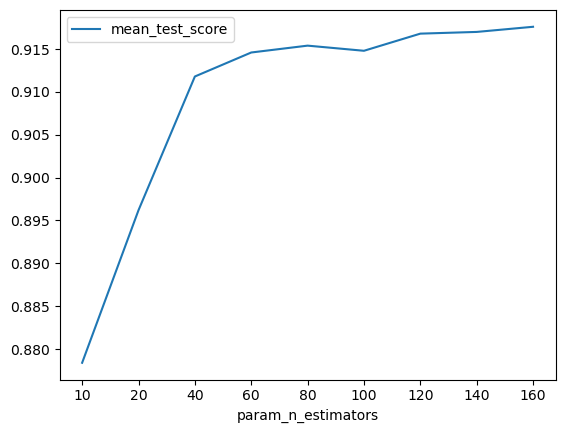

In [21]:
results.plot('param_n_estimators', 'mean_test_score');

The accuracy plateaus after about 100 trees, I will therfore use this parameter from here on.

We can also try to optimize the option 'max_features', which is the number of features to consider when looking for the best split. But as shown below, there are hardly any differences in the test scores (and the results are inconsistent, depending on the random state). I will therefore just keep the 'auto' option. 

In [22]:
parameters = {
    'max_features': ['auto', 15, 28, 50]}  # 28 = sqrt(784), which is suggested in the documentation as a good value

clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
rf = GridSearchCV(clf_rf, parameters, n_jobs=-1)
rf.fit(X_train, y_train)

results = pd.DataFrame(rf.cv_results_)
results.sort_values('mean_test_score', ascending=False)

C:\Users\tformatix\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tformatix\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tformatix\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\tformatix\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\tformatix\anaconda3\

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,3.084740,0.057998,3.548757,0.290903,15,{'max_features': 15},0.915,0.916,0.913,0.928,0.926,0.9196,0.006151,1
3,8.712810,0.159415,0.179516,0.126150,50,{'max_features': 50},0.918,0.909,0.910,0.922,0.923,0.9164,0.005886,2
2,4.601292,1.181074,3.714855,1.006473,28,{'max_features': 28},0.916,0.907,0.909,0.921,0.921,0.9148,0.005879,3
0,0.043162,0.003701,0.000000,0.000000,auto,{'max_features': 'auto'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


Let's run the random forest again with the selected options:

In [23]:
%%time

clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print('Random forest accuracy: ', acc_rf)

Random forest accuracy:  0.9044
CPU times: total: 7.92 s
Wall time: 1.21 s


We can visualize the model to see which pixels had the highest importance:

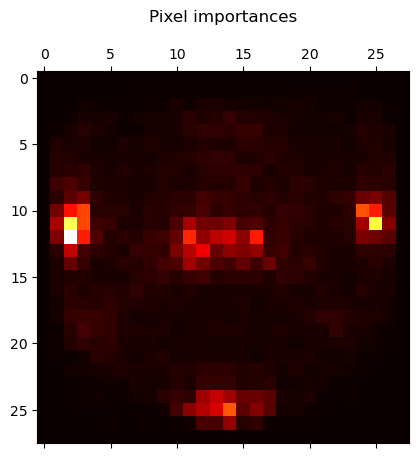

In [24]:
importances = clf_rf.feature_importances_
importances = importances.reshape((28, 28))
plt.matshow(importances, cmap=plt.cm.hot);
plt.title('Pixel importances\n');

As could be expected, corners have a very low importance, as they are mostly blank. The left, right, middle and bottom part of the picture are most important. Looking at the pictures of cats and sheeps, it seems that the middle is mostly blank in sheeps, but not in cats. So pixels there probably indicate a cat image. The other 'hot' areas are less clear to me after a quick inspection of the images.

## K-Nearest Neighbors (KNN)

Next, I will try out a KNN classifier:

In [27]:
%%time

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train, y_train)
print(clf_knn)
y_pred_knn = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print('KNN accuracy: ', acc_knn)

KNeighborsClassifier(n_jobs=-1)
KNN accuracy:  0.9218
CPU times: total: 1.31 s
Wall time: 726 ms


The KNN classifier looks promising, let's test different values of K:

In [28]:
%%time

parameters = {'n_neighbors': [1, 3, 5, 7, 9, 11]}

clf_knn = KNeighborsClassifier(n_jobs=-1)
knn = GridSearchCV(clf_knn, parameters, n_jobs=-1)
knn.fit(X_train, y_train)

results_knn = pd.DataFrame(knn.cv_results_)

CPU times: total: 46.9 ms
Wall time: 2.29 s


In [29]:
results_knn.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.031908,0.014034,0.741746,0.277366,7,{'n_neighbors': 7},0.927,0.924,0.918,0.919,0.925,0.9226,0.003499,1
2,0.027515,0.006960,1.271743,0.349151,5,{'n_neighbors': 5},0.923,0.929,0.909,0.932,0.913,0.9212,0.008908,2
4,0.092166,0.072029,0.631913,0.024826,9,{'n_neighbors': 9},0.924,0.923,0.915,0.921,0.922,0.9210,0.003162,3
1,0.030190,0.001543,1.173425,0.315192,3,{'n_neighbors': 3},0.918,0.929,0.912,0.927,0.915,0.9202,0.006675,4
5,0.112925,0.073819,0.453412,0.047988,11,{'n_neighbors': 11},0.921,0.921,0.913,0.916,0.921,0.9184,0.003323,5
0,0.030327,0.000741,1.275049,0.238336,1,{'n_neighbors': 1},0.918,0.914,0.901,0.912,0.921,0.9132,0.006853,6


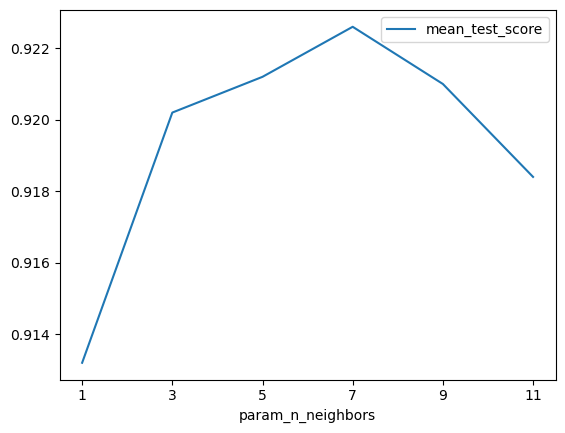

In [30]:
results_knn.plot('param_n_neighbors', 'mean_test_score');

The default option of k=5 seems to be optimal.
The KNN classifier is quite a bit more accurate than the random forest, but it also takes much longer (particularly the classification of new examples).

## Support Vector Machines (SVMs)

There are different implementations of SVMs in scikit-learn, I will try out three of them, the first two are linear SVMs, the third is a non linear:

In [31]:
%%time

clf_sgd = SGDClassifier(loss='hinge', random_state=0)  # loss='hinge' results in a linear SVM
clf_sgd.fit(X_train, y_train)
print(clf_sgd)
y_pred_sgd = clf_sgd.predict(X_test)
acc_sgd = accuracy_score(y_test, y_pred_sgd)
print('SVM stochastic gradient descent accuracy: ', acc_sgd)

SGDClassifier(random_state=0)
SVM stochastic gradient descent accuracy:  0.804
CPU times: total: 484 ms
Wall time: 558 ms


In [32]:
%%time

clf_svm = LinearSVC(random_state=0)
clf_svm.fit(X_train, y_train)
print(clf_svm)
y_pred_svm = clf_svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print('Linear SVM accuracy: ', acc_svm)

C:\Users\tformatix\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(random_state=0)
Linear SVM accuracy:  0.8498
CPU times: total: 1.28 s
Wall time: 1.79 s


C:\Users\tformatix\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [33]:
%%time

clf_svm = SVC(kernel='rbf', random_state=0)  # using the Gaussian radial basis function
clf_svm.fit(X_train, y_train)
print(clf_svm)
y_pred_svm = clf_svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print('RBF SVM accuracy: ', acc_svm)

SVC(random_state=0)
RBF SVM accuracy:  0.9258
CPU times: total: 6.58 s
Wall time: 7.06 s


The SVMs seem not very promising. There are of course many parameters that could be optimized, but I will focus on other methods here.

##  Multi-Layer Perceptron (MLP)

Let's try out a simple neural network in scikit-learn:

In [34]:
%%time

clf_mlp = MLPClassifier(random_state=0)
clf_mlp.fit(X_train, y_train)
print(clf_mlp)
y_pred_mlp = clf_mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print('mlp accuracy: ', acc_mlp)

MLPClassifier(random_state=0)
mlp accuracy:  0.9202
CPU times: total: 13.2 s
Wall time: 2.85 s


Compare different hidden_layer_sizes:

In [35]:
parameters = {
    'hidden_layer_sizes': [(50,), (100,), (784,), (50, 50), (100, 100), (784, 784), (50, 50, 50), (100, 100, 100)]}

clf_mlp = MLPClassifier(random_state=0)
mlp = GridSearchCV(clf_mlp, parameters, n_jobs=-1)
mlp.fit(X_train, y_train)

results = pd.DataFrame(mlp.cv_results_)
results.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,85.296128,1.677012,0.034167,0.006840,"(784, 784)","{'hidden_layer_sizes': (784, 784)}",0.931,0.927,0.937,0.936,0.943,0.9348,0.005455,1
2,95.899918,2.950549,0.048097,0.011356,"(784,)","{'hidden_layer_sizes': (784,)}",0.931,0.929,0.932,0.935,0.933,0.9320,0.002000,2
1,18.289129,0.851479,0.020679,0.002372,"(100,)","{'hidden_layer_sizes': (100,)}",0.930,0.922,0.925,0.928,0.929,0.9268,0.002926,3
4,10.406044,1.429104,0.026197,0.005817,"(100, 100)","{'hidden_layer_sizes': (100, 100)}",0.928,0.919,0.927,0.928,0.924,0.9252,0.003429,4
0,14.517234,2.374122,0.012328,0.002974,"(50,)","{'hidden_layer_sizes': (50,)}",0.922,0.918,0.917,0.926,0.927,0.9220,0.004050,5
3,9.028086,1.515905,0.018851,0.005263,"(50, 50)","{'hidden_layer_sizes': (50, 50)}",0.909,0.918,0.910,0.925,0.928,0.9180,0.007668,6
7,8.769584,0.442972,0.024235,0.005035,"(100, 100, 100)","{'hidden_layer_sizes': (100, 100, 100)}",0.912,0.912,0.919,0.920,0.927,0.9180,0.005621,6
6,7.928698,1.887211,0.026130,0.006471,"(50, 50, 50)","{'hidden_layer_sizes': (50, 50, 50)}",0.912,0.912,0.912,0.928,0.912,0.9152,0.006400,8


The larger neural nets with one or two layers of 784 (= number of input pixels) have clearly the highest accuracy. However, they also take a very long training time. I will therefore continue with the (100, 100) size, which is much faster and still has quite a high accuracy.

I will test as well different learning rates alpha:

In [36]:
parameters = {'alpha': list(10.0 ** -np.arange(1, 7))}

clf_mlp = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=0)
mlp = GridSearchCV(clf_mlp, parameters, n_jobs=-1)
mlp.fit(X_train, y_train)

results = pd.DataFrame(mlp.cv_results_)
results.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,10.710274,1.186887,0.025180,0.005795,0.001,{'alpha': 0.001},0.931,0.920,0.932,0.927,0.925,0.9270,0.004336,1
3,9.086308,1.232093,0.018386,0.004154,0.0001,{'alpha': 0.0001},0.928,0.919,0.927,0.928,0.924,0.9252,0.003429,2
5,7.193070,1.548167,0.006723,0.001173,0.000001,{'alpha': 1e-06},0.930,0.918,0.926,0.926,0.921,0.9242,0.004214,3
0,20.081992,3.683905,0.022010,0.003863,0.1,{'alpha': 0.1},0.924,0.910,0.932,0.919,0.934,0.9238,0.008773,4
1,10.044514,1.090350,0.021068,0.007064,0.01,{'alpha': 0.01},0.929,0.916,0.926,0.926,0.921,0.9236,0.004587,5
4,9.345269,0.416719,0.012229,0.004433,0.00001,{'alpha': 1e-05},0.928,0.919,0.924,0.922,0.921,0.9228,0.003059,6


Let's use the model with the selected parameters to test its accuracy on the test set:

In [37]:
%%time

clf_mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 100), random_state=0)
clf_mlp.fit(X_train, y_train)
print(clf_mlp)
y_pred_mlp = clf_mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print('MLP accuracy: ', acc_mlp)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 100), random_state=0)
MLP accuracy:  0.92
CPU times: total: 8.5 s
Wall time: 2.84 s


The MLPC classifier gives a similar accuracy as KNN, but is a bit faster.

## Convolutional Neural Network (CNN)

Let's try out a Convolutional Neural Network (CNN) with Keras. I will use a model from this [tutorial](http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/) by Jason Brownlee. It has the following 9 layers:

1. Convolutional layer with 30 feature maps of size 5×5. 
2. Pooling layer taking the max over 2*2 patches. 
3. Convolutional layer with 15 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 20%. 
6. Flatten layer. 
7. Fully connected layer with 128 neurons and rectifier activation. 
8. Fully connected layer with 50 neurons and rectifier activation. 
9. Output layer.

Keras requires one hot encoding of the y labels:

In [38]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

We also need to reshape the images to the original 28x28 shape, which gives the neural net additional information compared to a 784x1 vector.

In [39]:
# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [40]:
# define the CNN model
def cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [41]:
%%time

np.random.seed(0)
# build the model
model_cnn = cnn_model()
# Fit the model
model_cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

Epoch 1/10
25/25 [==============================] - 2s 35ms/step - loss: 0.4737 - accuracy: 0.8018 - val_loss: 0.3212 - val_accuracy: 0.8736
Epoch 2/10
25/25 [==============================] - 1s 27ms/step - loss: 0.2701 - accuracy: 0.8866 - val_loss: 0.2452 - val_accuracy: 0.9024
Epoch 3/10
25/25 [==============================] - 1s 27ms/step - loss: 0.2153 - accuracy: 0.9108 - val_loss: 0.2186 - val_accuracy: 0.9114
Epoch 4/10
25/25 [==============================] - 1s 28ms/step - loss: 0.1870 - accuracy: 0.9278 - val_loss: 0.1868 - val_accuracy: 0.9290
Epoch 5/10
25/25 [==============================] - 1s 27ms/step - loss: 0.1639 - accuracy: 0.9354 - val_loss: 0.1722 - val_accuracy: 0.9332
Epoch 6/10
25/25 [==============================] - 1s 27ms/step - loss: 0.1577 - accuracy: 0.9392 - val_loss: 0.1624 - val_accuracy: 0.9366
Epoch 7/10
25/25 [==============================] - 1s 27ms/step - loss: 0.1499 - accuracy: 0.9460 - val_loss: 0.1655 - val_accuracy: 0.9356
Epoch 8/10
25

As expected for an image classification task, the CNN has a very high accuracy with over 94%. But it also required the longest training time.

## Comparing different methods

Next, I will compare the most promising algorithms using different numbers of training examples.

In [43]:
%%time

np.random.seed(0)

N_train = [500, 2000, 5000, 10000, 15000]  # the number of training examples to be used
acc_scores = pd.DataFrame()

for i in N_train:
    # preprocessing as before with different sample sizes:
    X = np.concatenate((cat[:i, :-1], sheep[:i, :-1]), axis=0).astype('float32')
    y = np.concatenate((cat[:i, -1], sheep[:i, -1]), axis=0).astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X / 255., y, test_size=0.5, random_state=0)

    # run the different scikit-learn models:
    clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    acc_rf = clf_rf.score(X_test, y_test)
    acc_scores.set_value('RF', i, acc_rf)

    clf_knn = KNeighborsClassifier(n_jobs=-1)
    clf_knn.fit(X_train, y_train)
    acc_knn = clf_knn.score(X_test, y_test)
    acc_scores.set_value('KNN', i, acc_knn)

    clf_mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50))
    clf_mlp.fit(X_train, y_train)
    acc_mlp = clf_mlp.score(X_test, y_test)
    acc_scores.set_value('MLP', i, acc_mlp)

    # preprocessing for keras:
    y_train_cnn = np_utils.to_categorical(y_train)
    y_test_cnn = np_utils.to_categorical(y_test)
    num_classes = y_test_cnn.shape[1]
    X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

    # run the keras model:
    model = cnn_model()
    model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=10, batch_size=200, verbose=0)
    scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
    acc_scores.set_value('CNN', i, scores[1])


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\tformatix\anaconda3\Lib\site-packages\IPython\core\magics\execution.py", line 1340, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 16, in <module>
  File "C:\Users\tformatix\anaconda3\Lib\site-packages\pandas\core\generic.py", line 5989, in __getattr__
    return object.__getattribute__(self, name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'DataFrame' object has no attribute 'set_value'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\tformatix\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tformatix\anaconda3\Lib\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^

In [34]:
acc_scores

,500,2000,5000,10000,15000
RF,0.868,0.9030,0.8992,0.9210,0.926867
KNN,0.862,0.9060,0.9218,0.9322,0.936400
MLP,0.860,0.8945,0.9140,0.9299,0.932933
CNN,0.892,0.9315,0.9392,0.9560,0.964200


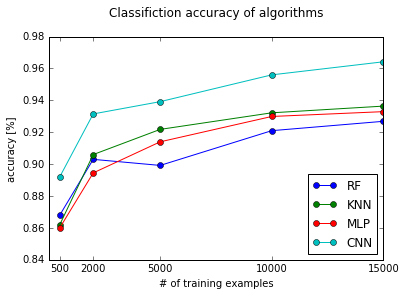

In [35]:
acc_scores.transpose().plot(xticks=list(acc_scores), xlim=(0, 15000), marker='o',
                            title='Classifiction accuracy of algorithms\n');
plt.xlabel('# of training examples');
plt.ylabel('accuracy [%]');

## Evaluation metrics of the CNN model

I will look at some evaluation metrics of the best performing CNN model. The fitted model is still stored in the workspace, but we also need to save the predictions on the test set:

In [36]:
y_pred_cnn = model.predict_classes(X_test_cnn, verbose=0)

In [37]:
acc_cnn = accuracy_score(y_test, y_pred_cnn)
print('CNN accuracy: ', acc_cnn)

CNN accuracy:  0.9642


I have run this script several times, and the accuracy varies around 96% due to the randomness during the fitting of the model.

The confusion matrix shows how many predctions were right and wrong, and what types of error were made (again, the results could differ if you rerun the script):

Confusion matrix, without normalization
[[7253  244]
 [ 293 7210]]


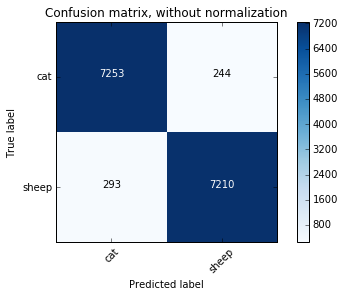

In [38]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_cnn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['cat', 'sheep'],
                      title='Confusion matrix, without normalization')

plt.show()

To see some of the images that were misclassified, I will select them:

In [39]:
sheep_not_cats = X_test[y_test > y_pred_cnn]  # true: 1 (sheep), predicted: 0 (cat)
cats_not_sheep = X_test[y_test < y_pred_cnn]  # true: 0 (cat), predicted: 1 (sheep)

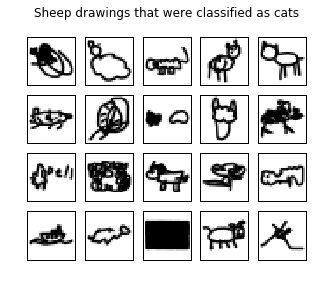

In [40]:
plot_samples(sheep_not_cats, title='Sheep drawings that were classified as cats\n')

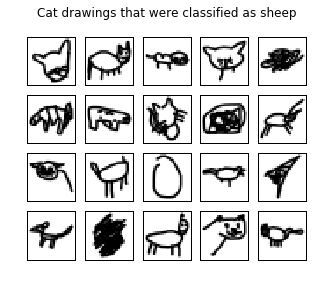

In [41]:
plot_samples(cats_not_sheep, title='Cat drawings that were classified as sheep\n')

Most of these drawings are really hard to classify, while some seem possible. But I "only" trained the CNN on 7'500 of the over 120'000 available examples per category. Thus, training on a significantly larger training set is possible and would certainly increase accuracy.

As a further evaluation of the classifier, I will draw the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and calculate the Area Under the Curve (AUC):

In [42]:
# store the predicted probabilities for class 1 (sheep)
y_pred_prob = model.predict_proba(X_test_cnn, verbose=0)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

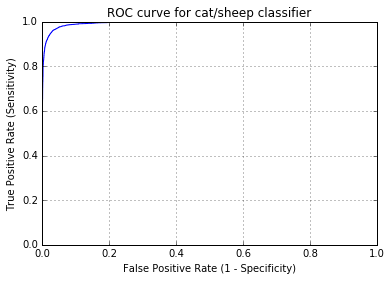

In [43]:
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve for cat/sheep classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [44]:
# calculate AUC score:
roc_auc_score(y_test, y_pred_prob)

0.99416554573315408

The AUC score is very good, over 99%.

## Multi-class Classification

Now let's make the classification a bit more difficult by comparing 5 classes:

In [45]:
# load the data
dog = np.load('data/dog.npy')
octopus = np.load('data/octopus.npy')
bee = np.load('data/bee.npy')
hedgehog = np.load('data/hedgehog.npy')
giraffe = np.load('data/giraffe.npy')

The data preprocessing is similar as in the case for 2 classes:

In [46]:
# add a column with labels
dog = np.c_[dog, np.zeros(len(dog))]
octopus = np.c_[octopus, np.ones(len(octopus))]
bee = np.c_[bee, 2 * np.ones(len(bee))]
hedgehog = np.c_[hedgehog, 3 * np.ones(len(hedgehog))]
giraffe = np.c_[giraffe, 4 * np.ones(len(giraffe))]

# store the label codes in a dictionary
label_dict = {0: 'dog', 1: 'octopus', 2: 'bee', 3: 'hedgehog', 4: 'giraffe'}

print(dog.shape)
print(octopus.shape)
print(bee.shape)
print(hedgehog.shape)
print(giraffe.shape)

(152159, 785)
(150152, 785)
(120890, 785)
(120527, 785)
(127182, 785)


Create the matrices for scikit-learn (5'000 images per class):

In [47]:
X = np.concatenate((dog[:5000, :-1], octopus[:5000, :-1], bee[:5000, :-1], hedgehog[:5000, :-1], giraffe[:5000, :-1]),
                   axis=0).astype('float32')  # all columns but the last
y = np.concatenate((dog[:5000, -1], octopus[:5000, -1], bee[:5000, -1], hedgehog[:5000, -1], giraffe[:5000, -1]),
                   axis=0).astype('float32')  # the last column

X_train, X_test, y_train, y_test = train_test_split(X / 255., y, test_size=0.5, random_state=0)

Use different scikit-learn algorithms to make predictions:

In [48]:
%%time

clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print('random forest accuracy: ', acc_rf)

random forest accuracy:  0.79104
Wall time: 8.7 s


In [49]:
%%time

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print('KNN accuracy: ', acc_knn)

KNN accuracy:  0.8236
Wall time: 1min 40s


In [50]:
%%time

clf_mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=(100, 100), random_state=0)
clf_mlp.fit(X_train, y_train)
y_pred_mlp = clf_mlp.predict(X_test)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print('mlp accuracy: ', acc_mlp)

mlp accuracy:  0.81176
Wall time: 35 s


Preprocessing for Keras:

In [51]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

In [52]:
# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [53]:
%%time

# build the model
model = cnn_model()
# Fit the model
model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

Train on 12500 samples, validate on 12500 samples
Epoch 1/10
12500/12500 [==============================] - 66s - loss: 1.0823 - acc: 0.5662 - val_loss: 0.6821 - val_acc: 0.7490
Epoch 2/10
12500/12500 [==============================] - 72s - loss: 0.6352 - acc: 0.7742 - val_loss: 0.5268 - val_acc: 0.8140
Epoch 3/10
12500/12500 [==============================] - 66s - loss: 0.5167 - acc: 0.8202 - val_loss: 0.4372 - val_acc: 0.8524
Epoch 4/10
12500/12500 [==============================] - 62s - loss: 0.4612 - acc: 0.8410 - val_loss: 0.3947 - val_acc: 0.8688
Epoch 5/10
12500/12500 [==============================] - 60s - loss: 0.4161 - acc: 0.8576 - val_loss: 0.3731 - val_acc: 0.8786
Epoch 6/10
12500/12500 [==============================] - 60s - loss: 0.3812 - acc: 0.8710 - val_loss: 0.3428 - val_acc: 0.8908
Epoch 7/10
12500/12500 [==============================] - 60s - loss: 0.3585 - acc: 0.8773 - val_loss: 0.3245 - val_acc: 0.8968
Epoch 8/10
12500/12500 [==============================

Again, the CNN with Keras performed best.

Let's take a look at the predictions of the CNN:

In [54]:
y_pred_cnn = model.predict_classes(X_test_cnn, batch_size=32, verbose=0)
acc_cnn = accuracy_score(y_test, y_pred_cnn)
print('CNN accuracy: ', acc_cnn)

CNN accuracy:  0.90288


Confusion matrix, without normalization
[[2257   55   73   60   48]
 [  87 2327   63   38   16]
 [ 181   71 2131   92   17]
 [ 125   23  105 2220    9]
 [ 105   21   15   10 2351]]


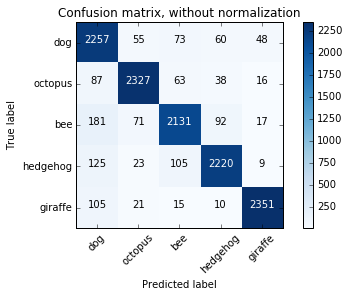

In [55]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_cnn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['dog', 'octopus', 'bee', 'hedgehog', 'giraffe'],
                      title='Confusion matrix, without normalization')

plt.show()

Let's see what probabilities were predicted by the model:

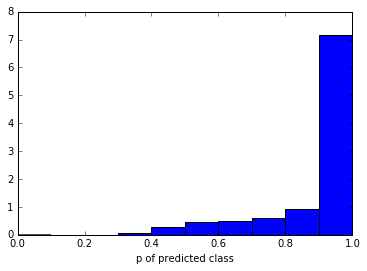

In [56]:
cnn_probab = model.predict(X_test_cnn, batch_size=32, verbose=0)

# extract the probability for the label that was predicted:
p_max = np.amax(cnn_probab, axis=1)

plt.hist(p_max, normed=True, bins=list(np.linspace(0, 1, 11)));
plt.xlabel('p of predicted class');

For about 70% of the pictures, the CNN predicted the label with > 90% certainty.

If the predictions of the CNN are well calibrated, the average prediction certainty should be equal to the accuracy (90%), which is indeed the case:

In [57]:
np.mean(p_max)

0.90004683

The lowest certainty of a prediction is about 25%:

In [58]:
np.amin(p_max)

0.24437894

Let's take a look at some predictions in detail:

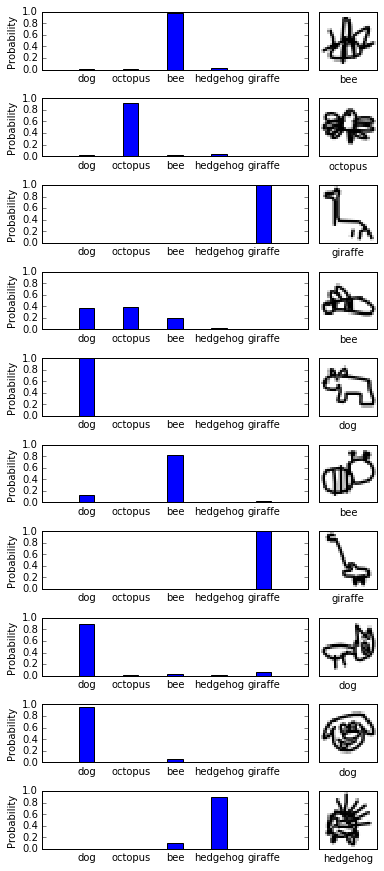

In [59]:
fig, ax = plt.subplots(figsize=(6, 15))

for i in list(range(10)):
    # plot probabilities:
    ax = plt.subplot2grid((10, 5), (i, 0), colspan=4);
    plt.bar(np.arange(5), cnn_probab[i], 0.35, align='center');
    plt.xticks(np.arange(5), ['dog', 'octopus', 'bee', 'hedgehog', 'giraffe'])
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.subplots_adjust(hspace=0.5)

    # plot picture:
    ax = plt.subplot2grid((10, 5), (i, 4));
    plt.imshow(X_test[i].reshape((28, 28)), cmap='gray_r', interpolation='nearest');
    plt.xlabel(label_dict[y_test[i]]);  # get the label from the dict
    plt.xticks([])
    plt.yticks([])

Let's take a look at some pictures where the CNN was very unsure about the label by filtering with [p_max<0.4]:

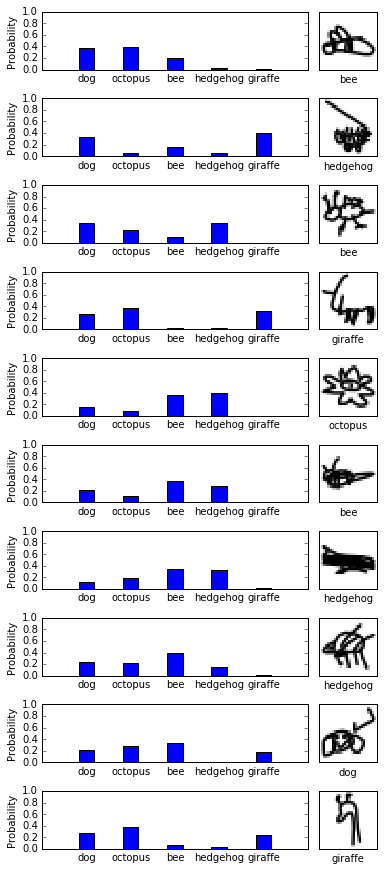

In [60]:
fig, ax = plt.subplots(figsize=(6, 15))

for i in list(range(10)):
    # plot probabilities:
    ax = plt.subplot2grid((10, 5), (i, 0), colspan=4);
    plt.bar(np.arange(5), cnn_probab[p_max < 0.4][i], 0.35, align='center');
    plt.xticks(np.arange(5), ['dog', 'octopus', 'bee', 'hedgehog', 'giraffe'])
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.subplots_adjust(hspace=0.5)

    # plot picture:
    ax = plt.subplot2grid((10, 5), (i, 4));
    plt.imshow(X_test[p_max < 0.4][i].reshape((28, 28)), cmap='gray_r', interpolation='nearest');
    plt.xlabel(label_dict[y_test[p_max < 0.4][i]]);  # get the label from the dict
    plt.xticks([])
    plt.yticks([])

It seems that there is still some room for improvement. Notably, I have used just about 2% of the pictures for training. By increasing that number, big increases in accuracy would certainly be possible.